In [ ]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.5 MB/s eta 0:

In [ ]:
#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try:
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.9 MB/s eta 0:00:00
  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
CPU times: user 174 ms, sys: 29.6 ms, total: 203 ms
Wall time: 21.8 s


In [ ]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

In [ ]:
import glob

def load_paired_data(folder_path):
    """
    Load images and their corresponding text prompts from a folder
    where files are paired as 1.jpg/1.txt, 2.jpg/2.txt, etc.
    """
    image_files = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))
    images = []
    prompts = []

    for img_path in image_files:
        # Get corresponding text file path
        txt_path = img_path.rsplit(".", 1)[0] + ".txt"

        if os.path.exists(txt_path):
            # Load image
            image = Image.open(img_path).convert("RGB")
            images.append(image)

            # Load prompt from text file
            with open(txt_path, 'r') as f:
                prompt = f.read().strip()
            prompts.append(prompt)

    return images, prompts

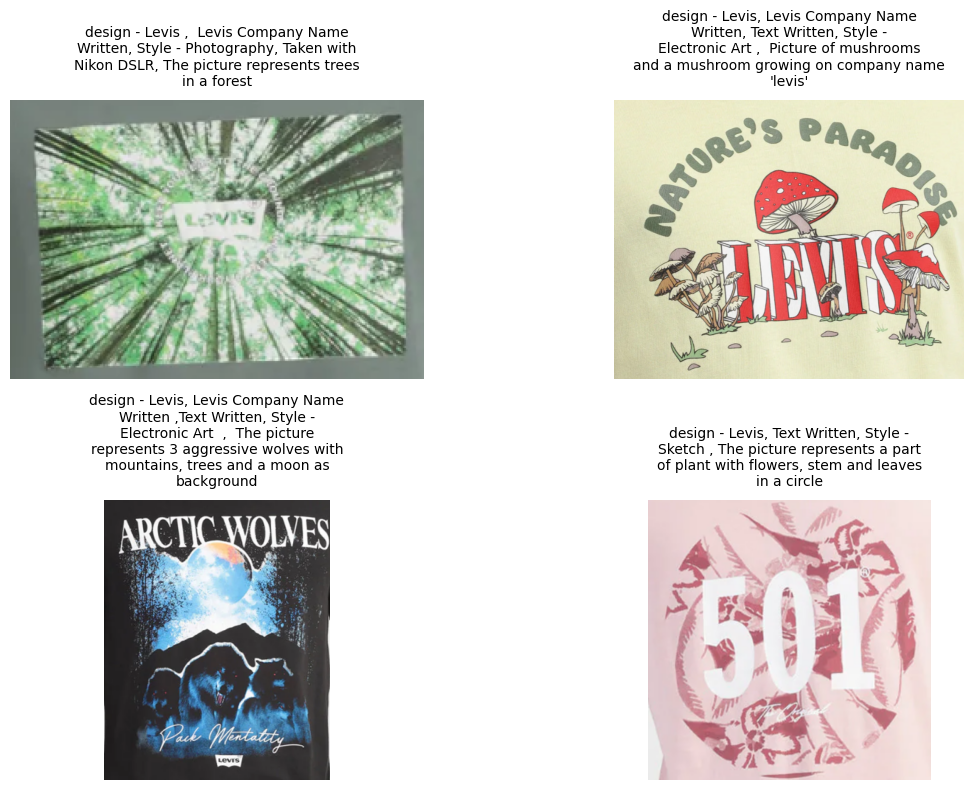

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from textwrap import wrap

# Set the folder path
folder_path = '/content/drive/MyDrive/Loras/tshirt/dataset'

# Get all image files (common formats)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = [file for file in os.listdir(folder_path) if os.path.splitext(file)[1].lower() in image_extensions]

# Randomly select 4 images
random_images = random.sample(image_files, 4)

# Configure grid dimensions
grid_size = (2, 2)  # 2 rows, 2 columns
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 8))

# Display images with their captions
for idx, image in enumerate(random_images):
    image_path = os.path.join(folder_path, image)
    caption_path = os.path.join(folder_path, os.path.splitext(image)[0] + '.txt')

    # Read the caption
    if os.path.exists(caption_path):
        with open(caption_path, 'r') as f:
            caption = f.read().strip()
    else:
        caption = "No caption found."

    # Wrap the caption to prevent merging
    wrapped_caption = "\n".join(wrap(caption, width=40))

    # Load the image
    img = Image.open(image_path)

    # Get the current axis
    ax = axes[idx // grid_size[1], idx % grid_size[1]]

    # Display the image and caption
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(wrapped_caption, fontsize=10, pad=10)

# Hide any unused subplots
for ax in axes.flatten()[len(random_images):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
``# Settings section
#@title Settings for your newly created concept
input_folder = "/content/drive/MyDrive/Loras/tshirt/dataset"  # @param {type:"string"}
instance_prompt = "<t-shirt> t-shirt"  # The token and type of object
prior_preservation = True  # Set to True to maintain general t-shirt characteristics
prior_preservation_class_prompt = "A tshirt design " # Generic t-shirt description
num_class_images = 120  # You might want more class images for clothing
prior_loss_weight = 1.0
# Load images and prompts from the folder
images, prompts = load_paired_data(input_folder)

# Save images to the concept folder
save_path = "/content/drive/MyDrive/Loras/tshirt/my_concept"
if not os.path.exists(save_path):
    os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

# Display the image grid
if images:
    image_grid(images, 1, len(images))

In [ ]:
num_class_images = 50  # Number of class examples to generate
sample_batch_size = 2  # How many images to generate at once
prior_loss_weight = 1  # Weight of the prior preservation loss

# Folders for class images
prior_preservation_class_folder = "/content/drive/MyDrive/Loras/tshirt/my_concept"  # Where to store class images
class_data_root = prior_preservation_class_folder   # Root directory for class data
class_prompt = prior_preservation_class_prompt

In [ ]:
class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example

class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [ ]:
#@title Generate Class Images

from pathlib import Path
from torchvision import transforms
import gc

if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: Futu

Number of class images to sample: 38.


Generating class images:   0%|          | 0/19 [00:00<?, ?it/s]

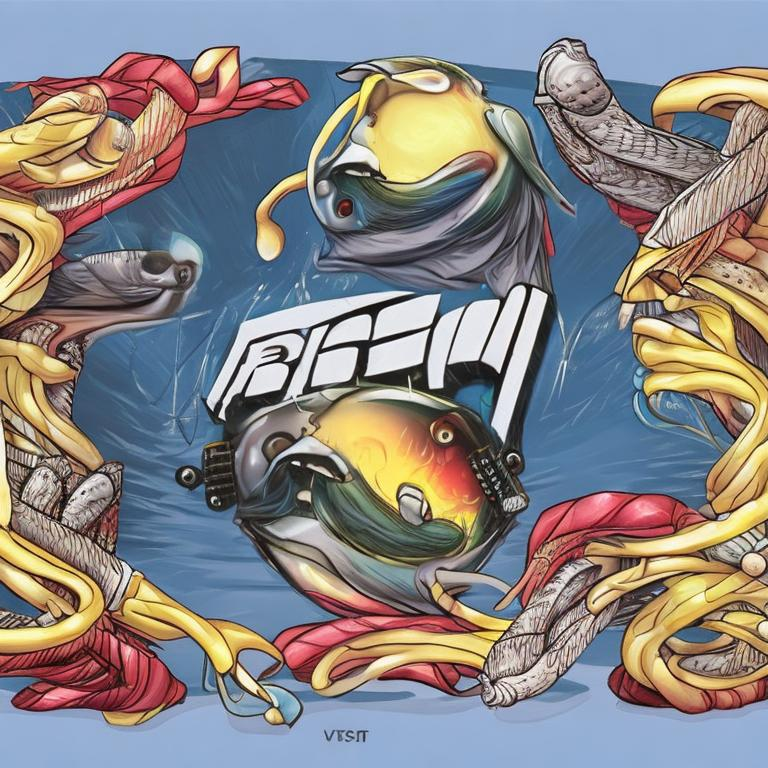

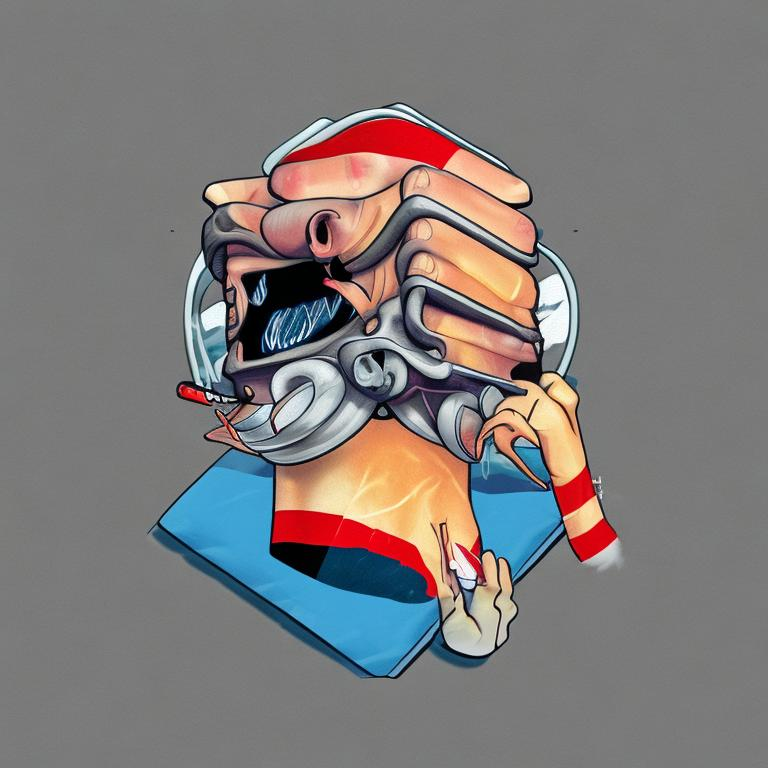

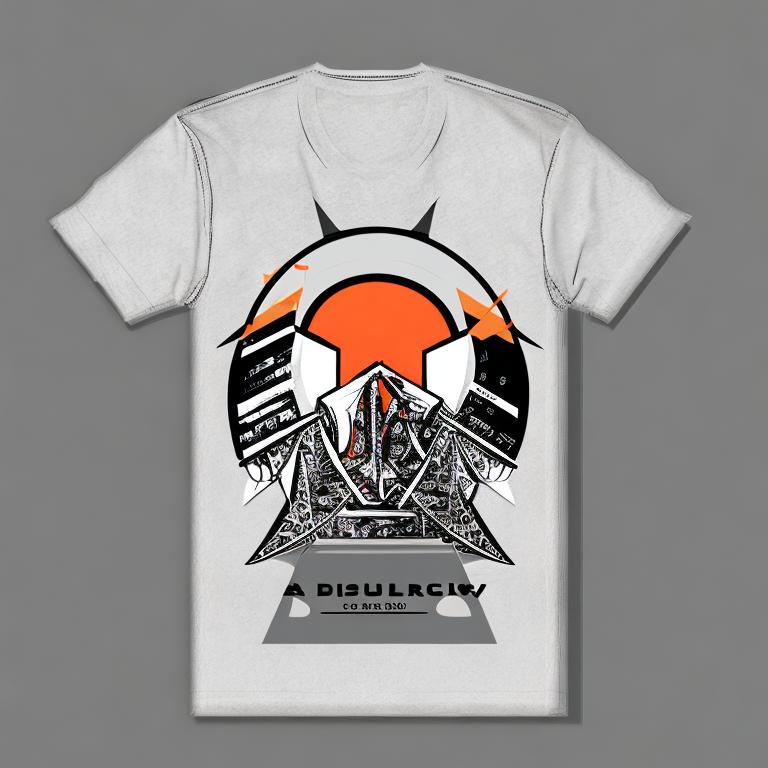

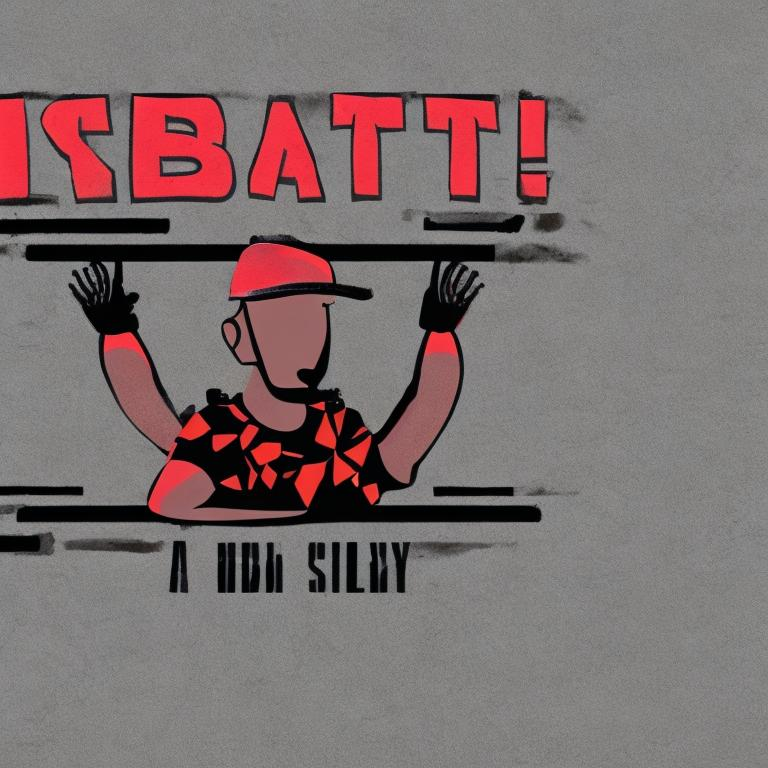

In [ ]:
import os
import random
from IPython.display import Image, display

# Folder containing the images
folder_path = "/content/drive/MyDrive/Loras/tshirt/my_concept"

# Get all files in the directory
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Filter image files (jpg, png, etc.)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Select 4 random images
random_images = random.sample(image_files, min(4, len(image_files)))

# Display the selected images
for image_path in random_images:
    display(Image(filename=image_path))


In [ ]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
#@title Setting up all training args
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=vae.sample_size,
    center_crop=True,
    train_text_encoder=False,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=800,
    save_steps=50,
    train_batch_size=2, # set to 1 if using prior preservation
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="dreambooth-concept",
)

<ipython-input-10-d19061d44c8d>:5: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,


In [ ]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = StableDiffusionPipeline.from_pretrained(
                            args.pretrained_model_name_or_path,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Launching training on one GPU.


  0%|          | 0/800 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import shutil
import os

# Define the source and destination folder paths
source_folder = '/content/dreambooth-concept/checkpoint-600'
destination_folder = '/content/drive/MyDrive/Loras/tshirt/finetunedmodal2'

# Make sure the destination folder exists; create it if it doesn't
os.makedirs(destination_folder, exist_ok=True)

# Copy each file and folder from source to destination
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)

    # If item is a directory, copy the entire directory
    if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
    # If item is a file, copy the file
    else:
        shutil.copy2(source_path, destination_path)

print("Copying complete!")


Copying complete!


In [ ]:
# First, mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Create a directory in your Google Drive to save the model
import os
save_directory = "/content/drive/MyDrive/Loras/tshirt/finetunedmodal2"
os.makedirs(save_directory, exist_ok=True)

# Save the model to Google Drive
# pipe = StableDiffusionPipeline.from_pretrained(
#     args.output_dir,
#     torch_dtype=torch.float16,
# ).to("cuda")
# pipe.save_pretrained(save_directory)

# Set up the pipeline with DPMSolver scheduler from the saved model
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    save_directory,
    scheduler = DPMSolverMultistepScheduler.from_pretrained(save_directory, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

# Function to create image grid
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Generate images using the model
def generate_images(prompt, num_samples=2, num_rows=1):
    all_images = []
    for _ in range(num_rows):
        images = pipe(
            prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=25,
            guidance_scale=9
        ).images
        all_images.extend(images)

    grid = image_grid(all_images, num_rows, num_samples)
    return grid

# # Example usage
# prompt = "a <t-shirt> Desighn - Levis, Levis Company Name Written, Text Written, Style - Electronic Art  ,  Picture of mountains and tigers"  # Replace with your token/prompt
# grid = generate_images(prompt, num_samples=2, num_rows=1)
# display(grid)

# # Save generated images to Drive (optional)
# output_dir = "/content/drive/MyDrive/Loras/tshirt/output"
# os.makedirs(output_dir, exist_ok=True)
# grid.save(f"{output_dir}/generated_grid.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

60 class images - 600 iteration

In [ ]:
prompt = "a <t-shirt>Desighn - Levis, Levis Company Name Written, Text Written, Style - Painting , The picture represents a bridge on a river and sand on the shor"  # Replace with your token/prompt
grid = generate_images(prompt, num_samples=4, num_rows=2)
display(grid)

# Save generated images to Drive (optional)
output_dir = "/content/drive/MyDrive/Loras/tshirt/output"
os.makedirs(output_dir, exist_ok=True)
grid.save(f"{output_dir}/generated_grid2.png")
grid.save(f"{output_dir}/generated_grid.png")

12 class images - 300 iterations

In [ ]:
# Example usage
prompt = "a <t-shirt>Desighn - Levis, Levis Company Name Written, Text Written, Style - Painting , The picture represents a bridge on a river and sand on the shor"  # Replace with your token/prompt
grid = generate_images(prompt, num_samples=4, num_rows=2)
display(grid)

# Save generated images to Drive (optional)
output_dir = "/content/drive/MyDrive/Loras/tshirt/output"
os.makedirs(output_dir, exist_ok=True)
grid.save(f"{output_dir}/generated_grid2.png")

In [ ]:
# Example usage
prompt = "a <t-shirt>Desighn - Levis, Levis Company Name Written, Style - Sketch , The picture represents a bridge on a river and sand on the shor"  # Replace with your token/prompt
grid = generate_images(prompt, num_samples=4, num_rows=2)
display(grid)

# Save generated images to Drive (optional)
output_dir = "/content/drive/MyDrive/Loras/tshirt/output"
os.makedirs(output_dir, exist_ok=True)
grid.save(f"{output_dir}/generated_grid3.png")

In [ ]:
# Example usage
prompt = "a <t-shirt>Desighn - Levis, Levis Company Name Written, Style - Sketch , The picture represents a bridge on a river and sand on the shor"  # Replace with your token/prompt
grid = generate_images(prompt, num_samples=4, num_rows=2)
display(grid)

# Save generated images to Drive (optional)
output_dir = "/content/drive/MyDrive/Loras/tshirt/output"
os.makedirs(output_dir, exist_ok=True)
grid.save(f"{output_dir}/generated_grid4.png")